In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import random as rand
import warnings

# environment settings
data_path = 'Data/'
warnings.filterwarnings('ignore')

# Deserialize previously saved data from "preprocessing"
filehandler = open(data_path+'train_pp.obj', 'rb')
df = pickle.load(filehandler)
filehandler.close()

In [2]:
def plot_cv_overfitting(classifier,param, param_range):
    train_scores,test_scores= validation_curve(estimator=classifier,
                                              X=X_train,
                                              y=y_train,
                                              param_name=param,
                                              param_range=param_range,
                                              cv=10)
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    
    fig = plt.figure(figsize=(10,5))
    
    plt.plot(param_range,
             train_mean,
             color='blue',
             marker='o' ,
             markersize=5,
             label='training accuracy')
    plt.fill_between(param_range,
                     train_mean+train_std,
                     train_mean-train_std,
                     alpha=0.15,color='blue')
    plt.plot(param_range,
             test_mean,
             color='green',
             linestyle="--",
             marker='s',
             markersize=5,
             label='validation accuracy')
    plt.fill_between(param_range,
                     test_mean+test_std,
                     test_mean-test_std,
                     alpha=0.15,color='green')
    plt.grid()
    plt.xscale('log')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6 ,1.1])
    plt.show()

In [3]:
def plot_cv_accuracy(classifier):
    train_sizes,train_scores,test_scores =\
                        learning_curve(estimator=classifier,
                                       X=X_train,
                                       y=y_train,
                                       train_sizes=np.linspace(0.1,1.0,10),
                                       cv=10,
                                       n_jobs=1)
    
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(train_sizes,
             train_mean,
             color='blue',
             marker='o' ,
             markersize=5,
             label='training accuracy')
    plt.fill_between(train_sizes,
                     train_mean+train_std,
                     train_mean-train_std,
                     alpha=0.15,color='blue')
    plt.plot(train_sizes,
             test_mean,
             color='green',
             linestyle="--",
             marker='s',
             markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes,
                     test_mean+test_std,
                     test_mean-test_std,
                     alpha=0.15,color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6 ,1.1])
    plt.show()

In [4]:
#open test set
test_path = data_path+"test.csv"
test_df = pd.read_csv(test_path, dtype={
    'PassengerId': str,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings/spouses aboard
    'Parch': 'uint8', # number of parents/children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'}) # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

#This part should be moved to preprocessing!
test_df = test_df.drop(['Ticket','Cabin'], axis=1)
test_df['Sex'] = [0 if x == 'male' else 1 for x in test_df['Sex'] ]
# Replace Age missing values with data generated from gaussian
nan_filter = test_df['Age'].isnull()
np.random.seed(666)
mu, sigma = norm.fit(test_df[-nan_filter]['Age'])
norm_dist = np.random.normal(mu, sigma, nan_filter.sum())
test_df.loc[nan_filter,'Age'] = norm_dist
# Replace Fare missing values with data generated from gaussian
nan_filter = test_df['Fare'].isnull()
np.random.seed(666)
mu, sigma = norm.fit(test_df[-nan_filter]['Fare'])
norm_dist = np.random.normal(mu, sigma, nan_filter.sum())
test_df.loc[nan_filter,'Fare'] = norm_dist
# Set to zero all ages below zero
test_df.loc[df.Age<0 , 'Age'] = 0

In [5]:
#Separate training set from target variables
y = np.asarray(df['Survived'])
f_df = pd.get_dummies(df[['Embarked']],drop_first=True)
df.drop(['Embarked'],axis=1,inplace=True)
df = pd.concat([df,f_df],axis=1)
X = df
X = X.drop(['Survived','Name'], axis=1)
X = np.asarray(X)
#Create training set and test set with split 0.2
X_train , X_test ,y_train,y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=y)

#Clean test_set
test_set = test_df
test_set=test_set.drop(['Name'], axis=1)
t_df = pd.get_dummies(test_set['Embarked'],drop_first=True)
test_set.drop(['Embarked'],axis=1,inplace=True)
test_set = pd.concat([test_set,t_df],axis=1)

In [6]:
import sklearn.ensemble as ske

#Kfold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)

#Initialization of Random Forest Classifier
rf = ske.RandomForestClassifier(n_estimators=10,
                                max_features=7,
                                criterion='gini',
                                bootstrap=True).fit(X_train, y_train)

#Cross-validation score saved in scores array
scores= []
for k,(train,test) in enumerate(kfold):
    rf.fit(X_train[train], y_train[train])
    rf_train_score = rf.score(X_train[test],y_train[test])
    scores.append(rf_train_score)
print("\nCV accuracy : {} +/- {}".format(np.mean(scores),np.std(scores)))
rf.fit(X_train,y_train)
rf_test_score=rf.score(X_test,y_test)
print("Random Forest test accuracies {}".format(rf_test_score))


CV accuracy : 0.7976601781202521 +/- 0.04739835467333277
Random Forest test accuracies 0.8097014925373134


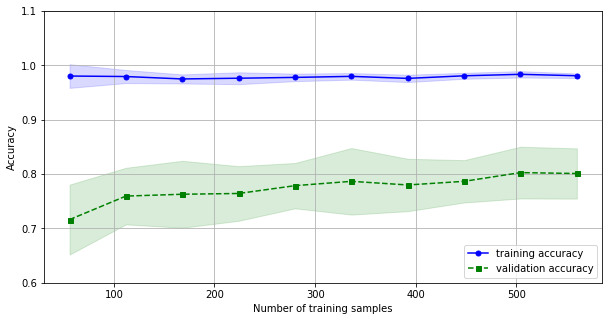

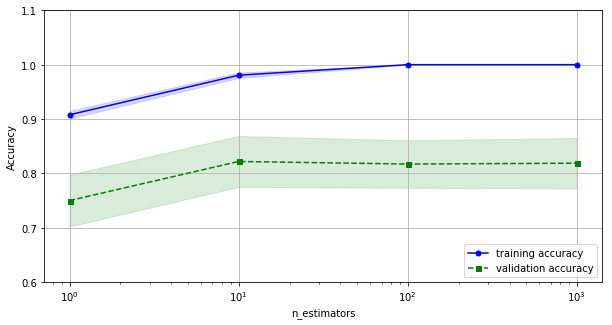

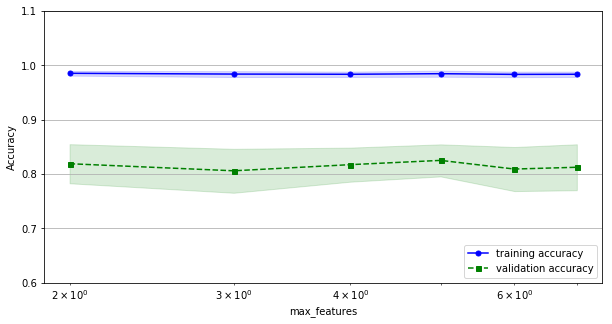

In [7]:
#Plotting graphs
plot_cv_accuracy(rf)
plot_cv_overfitting(rf,'n_estimators',[1,10,100,1000])
plot_cv_overfitting(rf,'max_features',[2,3,4,5,6,7])

In [8]:
#Prediction on real test set using random forest
survival_results =rf.predict(test_set)
result_df = pd.DataFrame(data={'PassengerId':test_df['PassengerId'].values,
                               'Survived':survival_results})
result_df['Survived'] = [0 if x == False else 1 for x in result_df['Survived'] ]
#Create output csv file
result_df.to_csv(data_path+"outputs/randomforest_ne_10.csv",index=False)

In [9]:
#TODO :automatic file naming with param values, clean test set in preprocessing, better graphs